## 1. Import Libraries

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv(r"C:\Users\pascal\Desktop\PROJECTS 2025\Multi-disease prediction models\multi-health-ml-predictor\data\heart_data.csv")


In [3]:
df.head()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.shape

(70000, 14)

In [5]:
# Rename columns for clarity
df.rename(columns={
    'age': 'age_days',
    'gender': 'sex',
    'height': 'height_cm',
    'weight': 'weight_kg',
    'ap_hi': 'systolic_bp',
    'ap_lo': 'diastolic_bp',
    'cholesterol': 'cholesterol_level',
    'gluc': 'glucose_level',
    'smoke': 'smoking',
    'alco': 'alcohol_intake',
    'active': 'physical_activity',
    'cardio': 'heart_disease'
}, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              70000 non-null  int64  
 1   id                 70000 non-null  int64  
 2   age_days           70000 non-null  int64  
 3   sex                70000 non-null  int64  
 4   height_cm          70000 non-null  int64  
 5   weight_kg          70000 non-null  float64
 6   systolic_bp        70000 non-null  int64  
 7   diastolic_bp       70000 non-null  int64  
 8   cholesterol_level  70000 non-null  int64  
 9   glucose_level      70000 non-null  int64  
 10  smoking            70000 non-null  int64  
 11  alcohol_intake     70000 non-null  int64  
 12  physical_activity  70000 non-null  int64  
 13  heart_disease      70000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 7.5 MB


In [7]:
# Convert age from days to years
df['age_years'] = (df['age_days'] // 365).astype(int)

In [8]:
# Drop age_days if you prefer
df.drop(columns='age_days', inplace=True)

In [9]:
df.head()

,index,id,sex,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_level,glucose_level,smoking,alcohol_intake,physical_activity,heart_disease,age_years
0,0,0,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,1,1,156,85.0,140,90,3,1,0,0,1,1,55
2,2,2,1,165,64.0,130,70,3,1,0,0,0,1,51
3,3,3,2,169,82.0,150,100,1,1,0,0,1,1,48
4,4,4,1,156,56.0,100,60,1,1,0,0,0,0,47


In [10]:
df.describe()

,index,id,sex,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_level,glucose_level,smoking,alcohol_intake,physical_activity,heart_disease,age_years
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,34999.500000,49972.419900,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,52.840671
std,20207.403759,28851.302323,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.766774
min,0.000000,0.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000
25%,17499.750000,25006.750000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000
50%,34999.500000,50001.500000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000
75%,52499.250000,74889.250000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000
max,69999.000000,99999.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000


In [11]:
missing_values = df.isnull().sum()
missing_values


index                0
id                   0
sex                  0
height_cm            0
weight_kg            0
systolic_bp          0
diastolic_bp         0
cholesterol_level    0
glucose_level        0
smoking              0
alcohol_intake       0
physical_activity    0
heart_disease        0
age_years            0
dtype: int64

In [12]:
duplicates = df.duplicated().sum()
duplicates

0

In [13]:
df.nunique()

index                70000
id                   70000
sex                      2
height_cm              109
weight_kg              287
systolic_bp            153
diastolic_bp           157
cholesterol_level        3
glucose_level            3
smoking                  2
alcohol_intake           2
physical_activity        2
heart_disease            2
age_years               28
dtype: int64

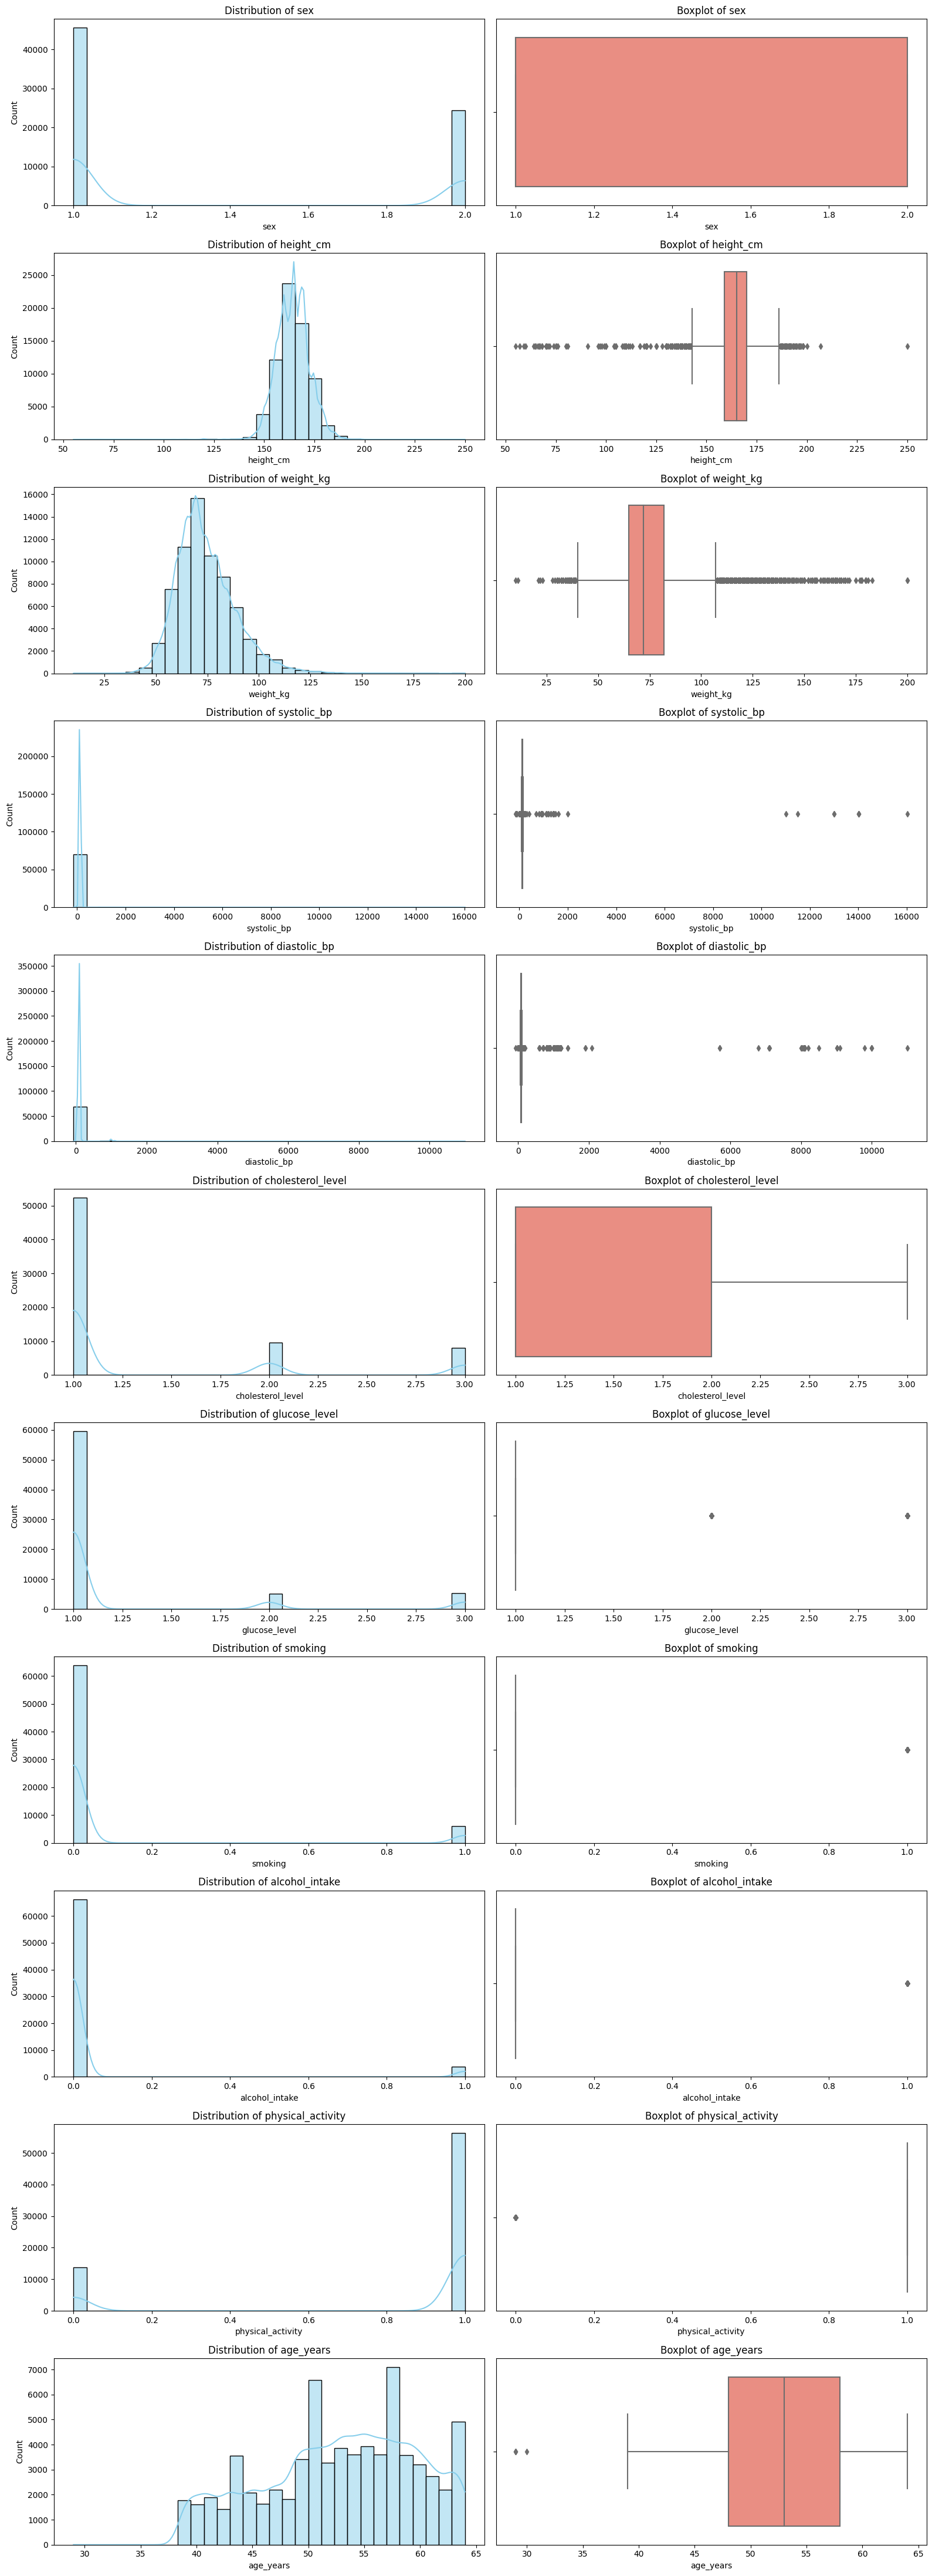

In [14]:
# Select only numerical columns (excluding index/id)
numerical_cols = df.select_dtypes(include=['int64', 'int32','float64']).drop(['index', 'id', 'heart_disease'], axis=1).columns

# Set up the plot grid
plt.figure(figsize=(16, len(numerical_cols) * 4))

for i, col in enumerate(numerical_cols, 1):
    # Histogram
    plt.subplot(len(numerical_cols), 2, 2*i - 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    
    # Boxplot
    plt.subplot(len(numerical_cols), 2, 2*i)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [15]:
# 1. Remove blood pressure outliers
df = df[(df['systolic_bp'].between(90, 250)) & 
        (df['diastolic_bp'].between(60, 140))]


In [16]:

# 2. Remove implausible height and weight
df = df[(df['height_cm'].between(120, 220)) & 
        (df['weight_kg'].between(30, 200))]

In [17]:
df['heart_disease'].value_counts(normalize=True)


0    0.504718
1    0.495282
Name: heart_disease, dtype: float64

In [18]:
df.dtypes

index                  int64
id                     int64
sex                    int64
height_cm              int64
weight_kg            float64
systolic_bp            int64
diastolic_bp           int64
cholesterol_level      int64
glucose_level          int64
smoking                int64
alcohol_intake         int64
physical_activity      int64
heart_disease          int64
age_years              int32
dtype: object

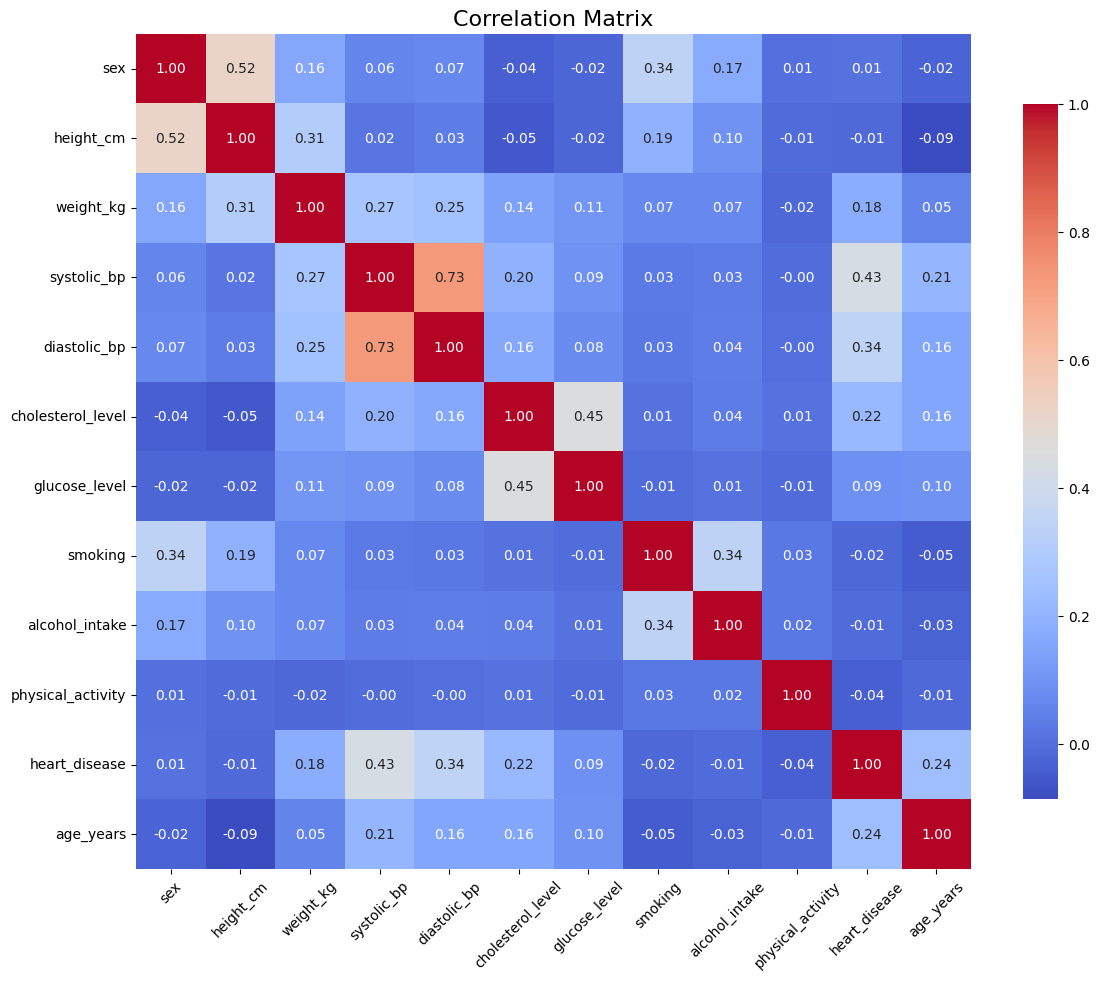

In [19]:
dfmodel = df.drop(columns=['index', 'id'])

# Compute correlation matrix
corr_matrix = dfmodel.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
corr_matrix 

,sex,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_level,glucose_level,smoking,alcohol_intake,physical_activity,heart_disease,age_years
sex,1.000000,0.516338,0.156641,0.061182,0.066947,-0.036856,-0.021207,0.338324,0.171259,0.005879,0.007063,-0.024113
height_cm,0.516338,1.000000,0.306034,0.016196,0.033458,-0.054991,-0.021391,0.194761,0.097828,-0.008004,-0.012471,-0.086406
weight_kg,0.156641,0.306034,1.000000,0.268657,0.252120,0.141044,0.106629,0.067637,0.068120,-0.017690,0.179526,0.054246
systolic_bp,0.061182,0.016196,0.268657,1.000000,0.727798,0.195632,0.093764,0.028512,0.034945,-0.002340,0.427218,0.208371
diastolic_bp,0.066947,0.033458,0.252120,0.727798,1.000000,0.162458,0.075143,0.026282,0.039856,-0.001040,0.342235,0.155012
cholesterol_level,-0.036856,-0.054991,0.141044,0.195632,0.162458,1.000000,0.450855,0.010186,0.035391,0.008611,0.221278,0.155078
glucose_level,-0.021207,-0.021391,0.106629,0.093764,0.075143,0.450855,1.000000,-0.005618,0.010452,-0.007771,0.089689,0.098590
smoking,0.338324,0.194761,0.067637,0.028512,0.026282,0.010186,-0.005618,1.000000,0.339941,0.025188,-0.015899,-0.047967
alcohol_intake,0.171259,0.097828,0.068120,0.034945,0.039856,0.035391,0.010452,0.339941,1.000000,0.024380,-0.007824,-0.028729
physical_activity,0.005879,-0.008004,-0.017690,-0.002340,-0.001040,0.008611,-0.007771,0.025188,0.024380,1.000000,-0.038045,-0.010434


In [21]:
dfmodel.head()

,sex,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_level,glucose_level,smoking,alcohol_intake,physical_activity,heart_disease,age_years
0,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,156,85.0,140,90,3,1,0,0,1,1,55
2,1,165,64.0,130,70,3,1,0,0,0,1,51
3,2,169,82.0,150,100,1,1,0,0,1,1,48
4,1,156,56.0,100,60,1,1,0,0,0,0,47


In [22]:
# pip install lightgbm

In [23]:
# pip install catboost

### Model Training and Evaluation

In [24]:

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

Training Logistic Regression...


c:\Users\pascal\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


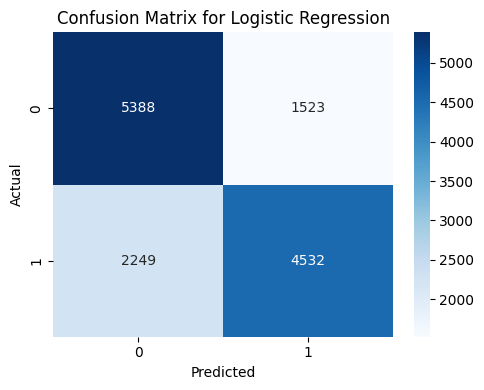

Training Random Forest...


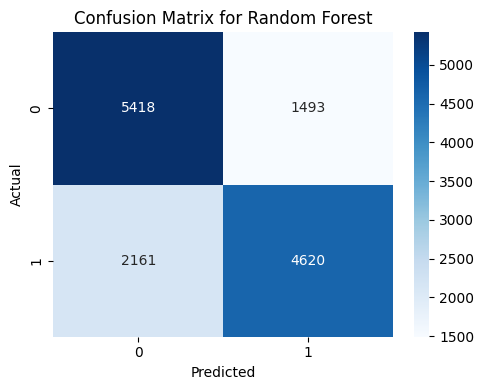

Training XGBoost...


c:\Users\pascal\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


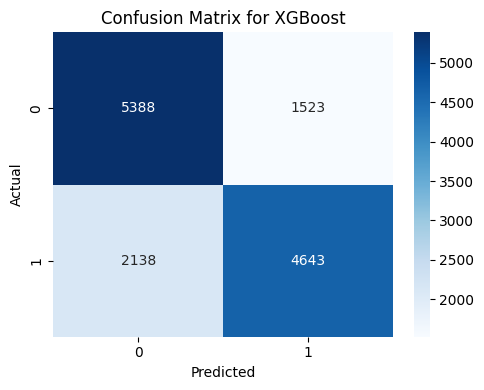

Training LightGBM...
[LightGBM] [Info] Number of positive: 27642, number of negative: 27642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 55284, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


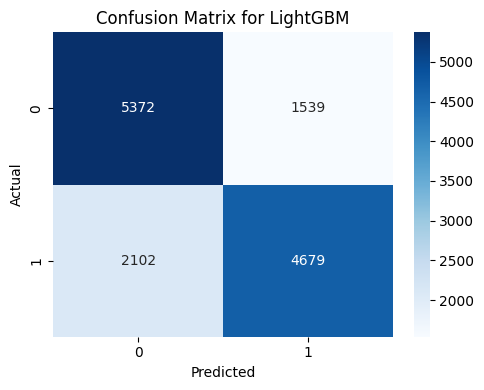

Training CatBoost...


c:\Users\pascal\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


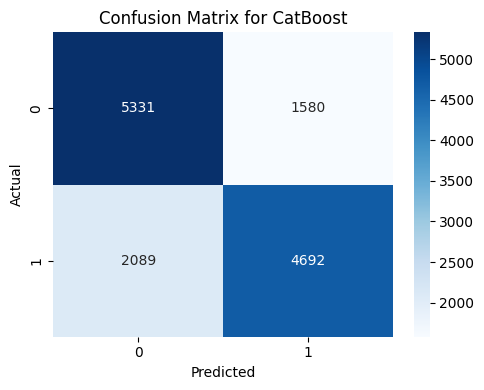


Model Performance Comparison:

                 Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
3             LightGBM    0.7341     0.7525  0.6900    0.7199   0.7981
1        Random Forest    0.7331     0.7558  0.6813    0.7166   0.7973
2              XGBoost    0.7326     0.7530  0.6847    0.7172   0.7986
4             CatBoost    0.7320     0.7481  0.6919    0.7189   0.7988
0  Logistic Regression    0.7245     0.7485  0.6683    0.7061   0.7886


In [25]:


# ========== Load Data ==========
numerical = [
    'systolic_bp', 'diastolic_bp', 'cholesterol_level', 'glucose_level',
    'weight_kg', 'age_years', 'physical_activity'
]

X = dfmodel[numerical]
y = dfmodel['heart_disease']

# ========== Split data ==========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========== Preprocessing ==========
scaler = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ========== Model configurations ==========
model_grid = [
    {
        'name': 'Logistic Regression',
        'pipeline': ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('scaler', scaler),
            ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
        ]),
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__solver': ['liblinear', 'lbfgs']
        }
    },
    {
        'name': 'Random Forest',
        'pipeline': ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2]
        }
    },
    {
        'name': 'XGBoost',
        'pipeline': ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__subsample': [0.8, 1.0]
        }
    },
    {
        'name': 'LightGBM',
        'pipeline': ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', LGBMClassifier(random_state=42))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [5, 10, -1],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__num_leaves': [31, 50]
        }
    },
    {
        'name': 'CatBoost',
        'pipeline': ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', CatBoostClassifier(verbose=0, random_state=42))
        ]),
        'params': {
            'classifier__iterations': [100, 200],
            'classifier__depth': [4, 6, 8],
            'classifier__learning_rate': [0.01, 0.1]
        }
    }
  
]
# ========== Run all models ==========
results = {
    'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [],
    'F1 Score': [], 'ROC AUC': []
}

for config in model_grid:
    print(f"Training {config['name']}...")
    search = RandomizedSearchCV(
        config['pipeline'], config['params'],
        scoring='f1', n_iter=20, cv=cv, random_state=42, n_jobs=-1
    )
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    results['Model'].append(config['name'])
    results['Accuracy'].append(round(accuracy_score(y_test, y_pred), 4))
    results['Precision'].append(round(precision_score(y_test, y_pred), 4))
    results['Recall'].append(round(recall_score(y_test, y_pred), 4))
    results['F1 Score'].append(round(f1_score(y_test, y_pred), 4))
    results['ROC AUC'].append(round(roc_auc_score(y_test, y_proba), 4) if y_proba is not None else 'N/A')

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {config["name"]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# ========== Display results ==========
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n")
print(results_df.sort_values(by='Accuracy', ascending=False))


In [26]:
import os
import pickle
import joblib
import warnings

#  suppress harmless warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [27]:


# 1. Get best model name from results
best_index = results_df['Accuracy'].idxmax()
best_model_name = results_df.loc[best_index, 'Model']
print(f"\n✅ Best Model (based on Accuracy): {best_model_name}")

# 2. Get that model's config from model_grid
best_config = next(cfg for cfg in model_grid if cfg['name'] == best_model_name)

# 3. Re-train the best model with best params
search = RandomizedSearchCV(
    best_config['pipeline'],
    best_config['params'],
    scoring='f1',
    n_iter=20,
    cv=cv,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)
final_model = search.best_estimator_





✅ Best Model (based on Accuracy): LightGBM
[LightGBM] [Info] Number of positive: 27642, number of negative: 27642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 55284, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [28]:
# 4. Save the model
model_name_safe = best_model_name.replace(" ", "_").lower()
save_path = r"C:\Users\pascal\Desktop\PROJECTS 2025\Multi-disease prediction models\multi-health-ml-predictor\models"
os.makedirs(save_path, exist_ok=True)


In [29]:

# Save as Pickle
pickle_path = os.path.join(save_path, f"{model_name_safe}_model.pkl")
with open(pickle_path, 'wb') as f:
    pickle.dump(final_model, f)

# Save as Joblib
joblib_path = os.path.join(save_path, f"{model_name_safe}_model.joblib")
joblib.dump(final_model, joblib_path)

print(f"\n✅ Saved best model as:\n→ Pickle: {pickle_path}\n→ Joblib: {joblib_path}")


✅ Saved best model as:
→ Pickle: C:\Users\pascal\Desktop\PROJECTS 2025\Multi-disease prediction models\multi-health-ml-predictor\models\lightgbm_model.pkl
→ Joblib: C:\Users\pascal\Desktop\PROJECTS 2025\Multi-disease prediction models\multi-health-ml-predictor\models\lightgbm_model.joblib
